# Opportunity 2

## Imports

In [62]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
from fbprophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
import math

warnings.simplefilter('ignore')

## Data setup

In [50]:
data_dir = Path('data')
stores_data = {}

for parquet_file in data_dir.glob('*.parquet*'):
    file_name = str(parquet_file).replace('data\sales-', '').replace('.parquet.gzip', '')
    stores_data[file_name] = {'sales_df': pd.read_parquet(parquet_file).drop(['SALES_DIST', 'SOLD_TO', 'SHIP_TO'], axis=1)}
    
stores_data

{'data/sales-7017139': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  327623    2019-03-04       425       1
  342880    2019-03-04     12080       1
  343841    2019-03-04      2639       1
  347866    2019-03-04     12026       1
  467020    2019-03-04     29772       2
  ...              ...       ...     ...
  186696013 2021-03-29     12793       2
  186696014 2021-03-29     22054       4
  186908262 2021-03-29     43004       1
  186915466 2021-03-29     16640       1
  186925567 2021-03-29     36717       2
  
  [4379 rows x 3 columns]},
 'data/sales-7003984': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  8511      2019-03-03      2641       1
  8512      2019-03-03     12916       1
  8513      2019-03-03      2464       1
  9478      2019-03-03     11074       1
  9479      2019-03-03     20306       1
  ...              ...       ...     ...
  141730332 2020-09-17     31907       2
  141730333 2020-09-17     36526       2
  141730334 2020-09-17     36879       1

## Get first and last date for each store

In [51]:
for store, data in stores_data.items():
    df_sorted_by_dates = data['sales_df'].sort_values(by='BILL_DATE')
    data['oldest_date'] = df_sorted_by_dates.iloc[0]["BILL_DATE"]
    data['newest_date'] = df_sorted_by_dates.iloc[-1]["BILL_DATE"]
    data['number_of_days'] = (data['newest_date']-data['oldest_date']).days + 1

## Top 10 most sold products per store

In [52]:
for store, data in stores_data.items():
    product_sales = data['sales_df'].groupby(['MATERIAL'])['PIEZAS'].sum().sort_values(ascending=False)
    data['top_products'] = product_sales.head(10)

stores_data

{'data/sales-7017139': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  327623    2019-03-04       425       1
  342880    2019-03-04     12080       1
  343841    2019-03-04      2639       1
  347866    2019-03-04     12026       1
  467020    2019-03-04     29772       2
  ...              ...       ...     ...
  186696013 2021-03-29     12793       2
  186696014 2021-03-29     22054       4
  186908262 2021-03-29     43004       1
  186915466 2021-03-29     16640       1
  186925567 2021-03-29     36717       2
  
  [4379 rows x 3 columns],
  'oldest_date': Timestamp('2019-03-04 00:00:00'),
  'newest_date': Timestamp('2021-03-29 00:00:00'),
  'number_of_days': 757,
  'top_products': MATERIAL
  4101     200
  13165    115
  4124     100
  19197     86
  4373      80
  4102      70
  9664      68
  3953      68
  3954      65
  4108      62
  Name: PIEZAS, dtype: int64},
 'data/sales-7003984': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  8511      2019-03-03      2641  

## Get daily sales of top 10 products of each store

In [53]:
for store, data in stores_data.items():
    idx = pd.date_range(data['oldest_date'], data['newest_date'])
    data['top_products_sales'] = {}
    for product, sale in data['top_products'].iteritems():
        product_series = data['sales_df'][data['sales_df']["MATERIAL"] == product]
        product_series = product_series.groupby('BILL_DATE').PIEZAS.sum().to_frame(name = 'PIEZAS')

        product_series.index = pd.DatetimeIndex(product_series.index)
        product_series = product_series.reindex(idx, fill_value=0)
        product_series.index.name = "BILL_DATE"
        product_series = product_series.reset_index()
        data['top_products_sales'][product] = product_series

stores_data

{'data/sales-7017139': {'sales_df':            BILL_DATE  MATERIAL  PIEZAS
  327623    2019-03-04       425       1
  342880    2019-03-04     12080       1
  343841    2019-03-04      2639       1
  347866    2019-03-04     12026       1
  467020    2019-03-04     29772       2
  ...              ...       ...     ...
  186696013 2021-03-29     12793       2
  186696014 2021-03-29     22054       4
  186908262 2021-03-29     43004       1
  186915466 2021-03-29     16640       1
  186925567 2021-03-29     36717       2
  
  [4379 rows x 3 columns],
  'oldest_date': Timestamp('2019-03-04 00:00:00'),
  'newest_date': Timestamp('2021-03-29 00:00:00'),
  'number_of_days': 757,
  'top_products': MATERIAL
  4101     200
  13165    115
  4124     100
  19197     86
  4373      80
  4102      70
  9664      68
  3953      68
  3954      65
  4108      62
  Name: PIEZAS, dtype: int64,
  'top_products_sales': {4101:      BILL_DATE  PIEZAS
   0   2019-03-04       0
   1   2019-03-05       0
   2

## Forecast the next 7 days for each of the top 10 products at each store

In [54]:
for store in stores_data:
    print(f'Store: {store}')
    stores_data[store]['models'] = {}
    stores_data[store]['predictions'] = {}
    stores_data[store]['fbp_objects'] = {}
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        daily_sales = stores_data[store]['top_products_sales'][product]
        daily_sales.columns = ['ds', 'y']
        m = Prophet(interval_width=0.95, daily_seasonality=True, yearly_seasonality=False) 
        stores_data[store]['models'][product] = m.fit(daily_sales)
        future = m.make_future_dataframe(periods=7, freq='D')
        forecast = m.predict(future)
        forecast = forecast.tail(7)
        stores_data[store]['predictions'][product] = forecast
        stores_data[store]['fbp_objects'][product] = m

Store: data/sales-7017139
Product: 4101
Initial log joint probability = -2.69
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       2013.82   1.03747e-05       91.7013   1.118e-07       0.001      132  LS failed, Hessian reset 
      99       2013.82   4.44049e-08       79.5661       0.348       0.348      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       2013.82    1.6798e-07       88.2881           1           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Product: 13165
Initial log joint probability = -2.78656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       1965.89   4.02349e-08       68.4739      0.2126           1       95   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Produc

## Round forecasted values and turn negative ones into 0

In [55]:
for store in stores_data:
    print(f'Store: {store}')
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        stores_data[store]['predictions'][product]['yhat'] = round(stores_data[store]['predictions'][product]['yhat'])
        stores_data[store]['predictions'][product][stores_data[store]['predictions'][product]['yhat'] <= 0]['yhat'] = 0
        print(stores_data[store]['predictions'][product])

Store: data/sales-7017139
Product: 4101
            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
757 2021-03-30  0.520879   -8.357482    9.124640     0.520879     0.520879   
758 2021-03-31  0.521483   -7.881255    8.033141     0.521483     0.521484   
759 2021-04-01  0.522086   -7.328526    8.371070     0.522082     0.522092   
760 2021-04-02  0.522690   -7.452874    8.838420     0.522677     0.522703   
761 2021-04-03  0.523293   -7.617061    7.972547     0.523272     0.523313   
762 2021-04-04  0.523897   -7.912688    8.362467     0.523863     0.523930   
763 2021-04-05  0.524500   -7.429710   10.132142     0.524456     0.524546   

     additive_terms  additive_terms_lower  additive_terms_upper     daily  \
757       -0.275565             -0.275565             -0.275565 -0.014196   
758       -0.276263             -0.276263             -0.276263 -0.014196   
759        0.000812              0.000812              0.000812 -0.014196   
760        0.185296        

## Plot models with all data

Store: data/sales-7017139
Product: 4101
Product: 13165
Product: 4124
Product: 19197
Product: 4373
Product: 4102
Product: 9664
Product: 3953
Product: 3954
Product: 4108
Store: data/sales-7003984
Product: 1564
Product: 4373
Product: 3439
Product: 12504
Product: 3008
Product: 6623
Product: 27752
Product: 4077
Product: 7904
Product: 4414
Store: data/sales-7023126
Product: 2541
Product: 29725
Product: 29258
Product: 38054
Product: 20791
Product: 3439
Product: 2342
Product: 12081
Product: 29257
Product: 16869
Store: data/sales-7029898
Product: 4373
Product: 3444
Product: 4103
Product: 1883
Product: 43629
Product: 6248
Product: 44066
Product: 18891
Product: 43598
Product: 15932
Store: data/sales-7007091
Product: 6969
Product: 6207
Product: 6962
Product: 6963
Product: 188
Product: 3591
Product: 3590
Product: 3556
Product: 6213
Product: 22572
Store: data/sales-7022906
Product: 15590
Product: 21256
Product: 8650
Product: 18761
Product: 28727
Product: 32002
Product: 28725
Product: 8657
Product: 2

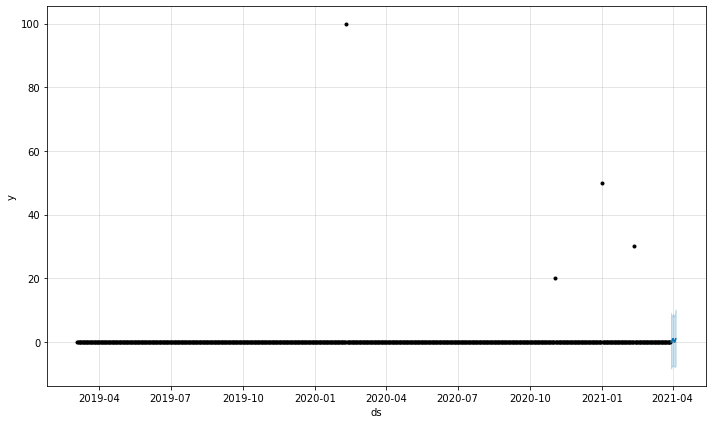

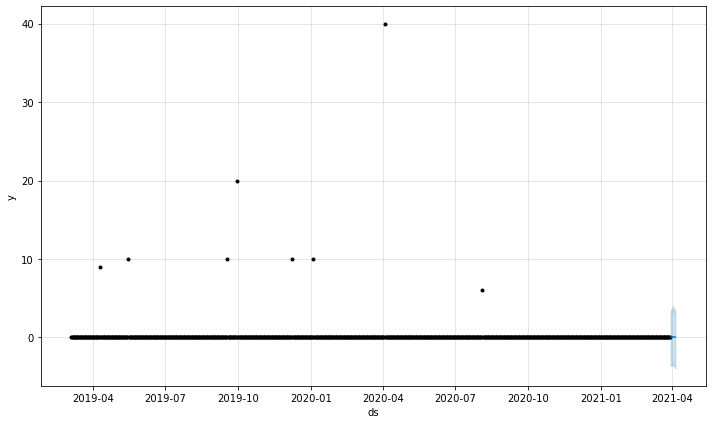

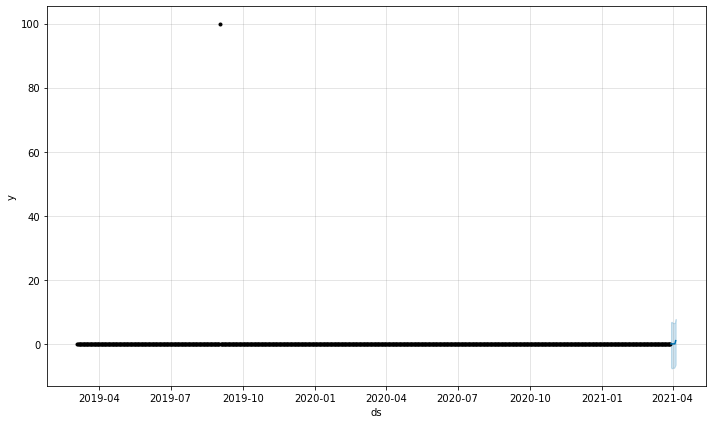

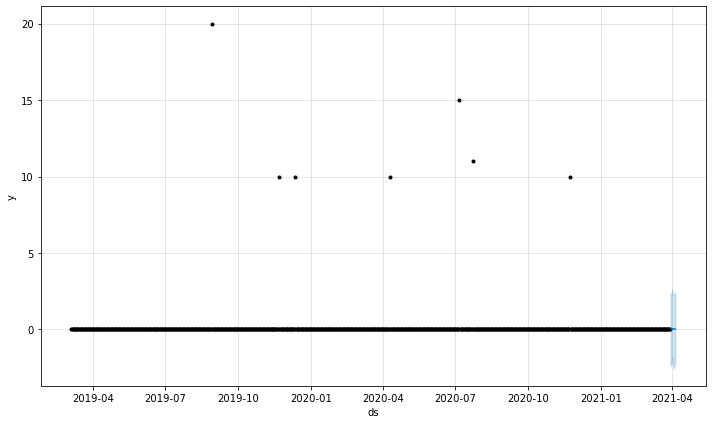

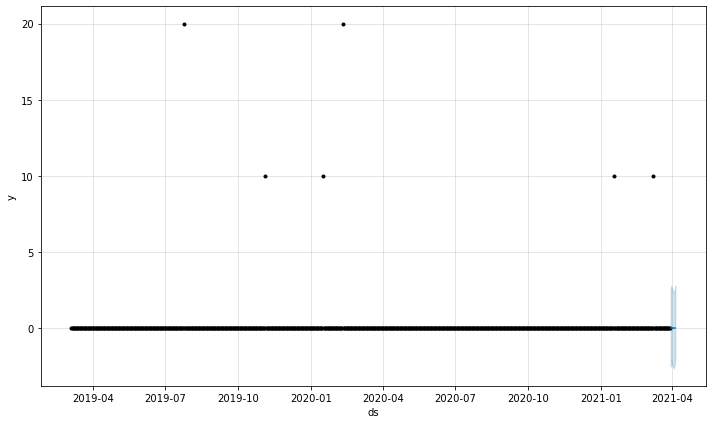

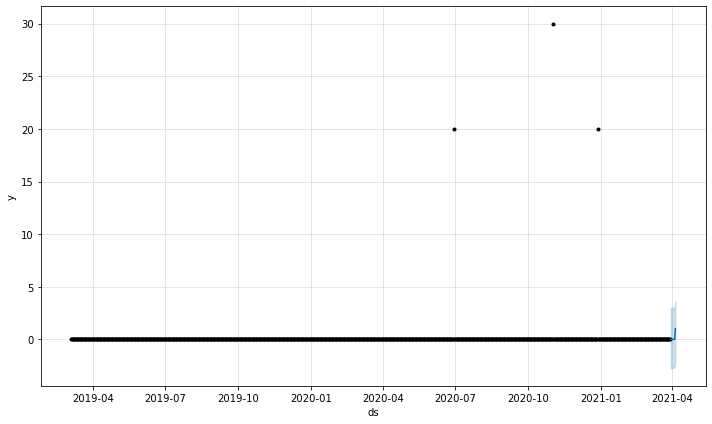

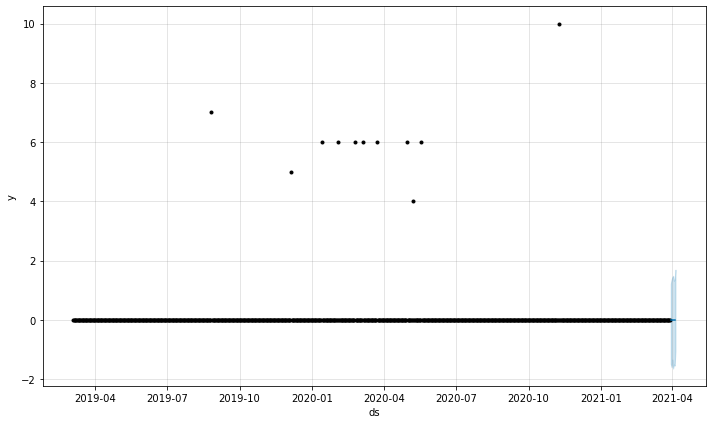

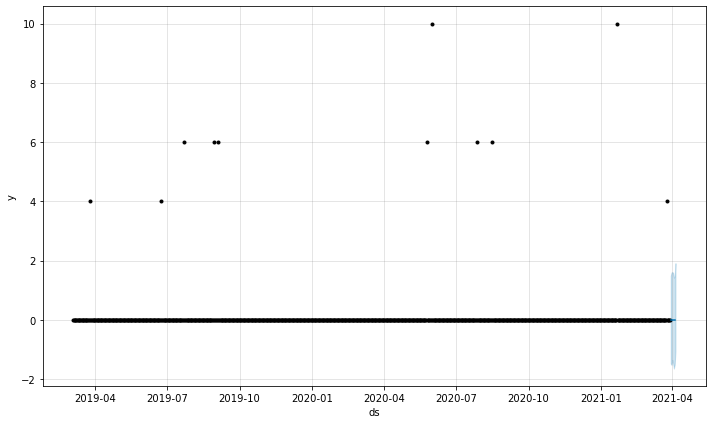

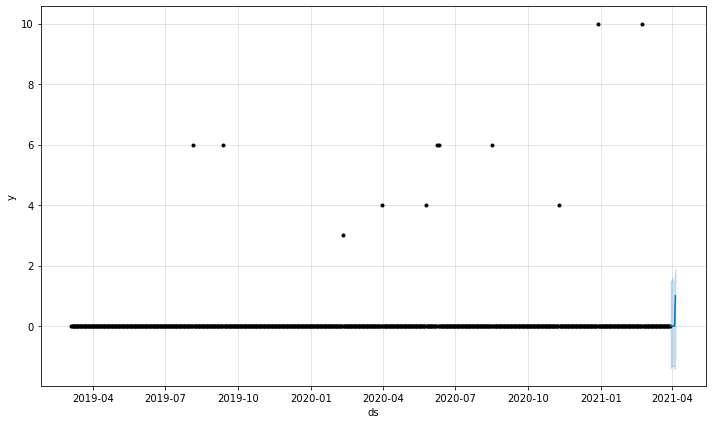

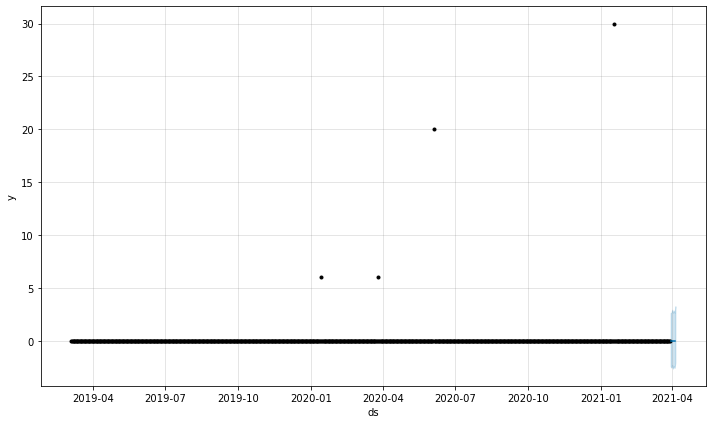

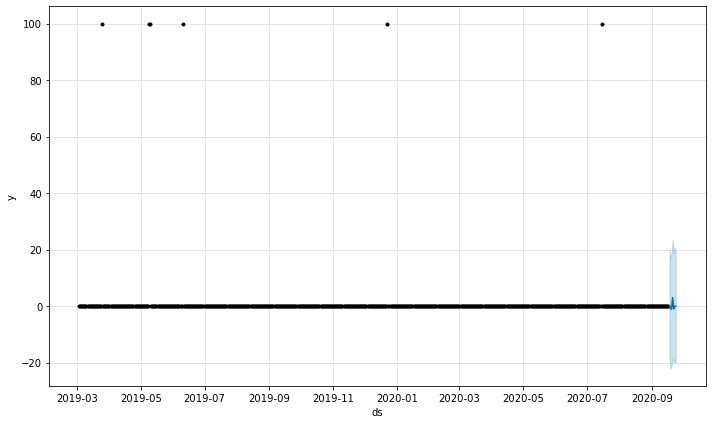

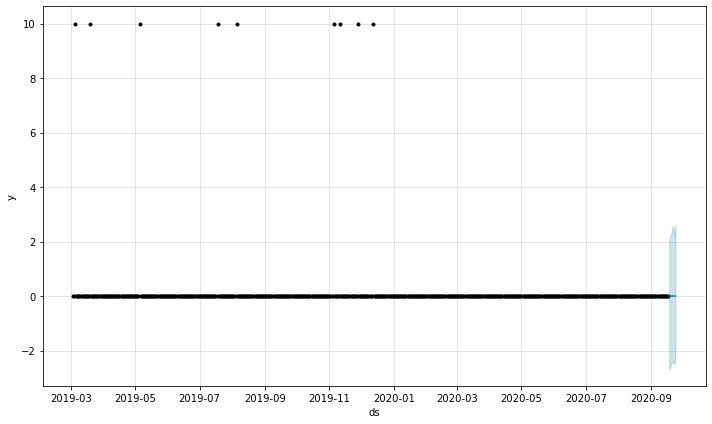

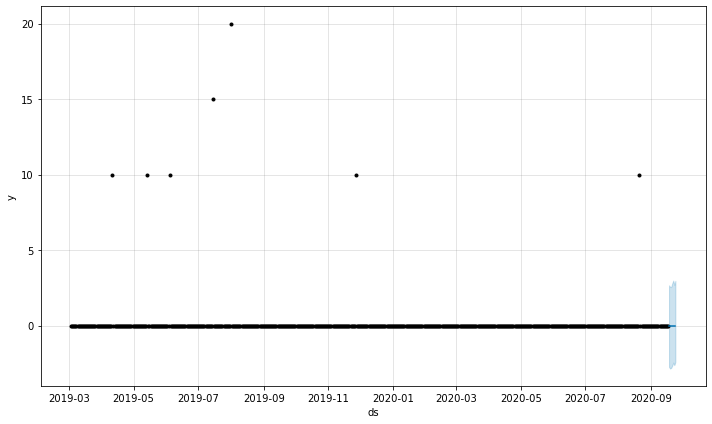

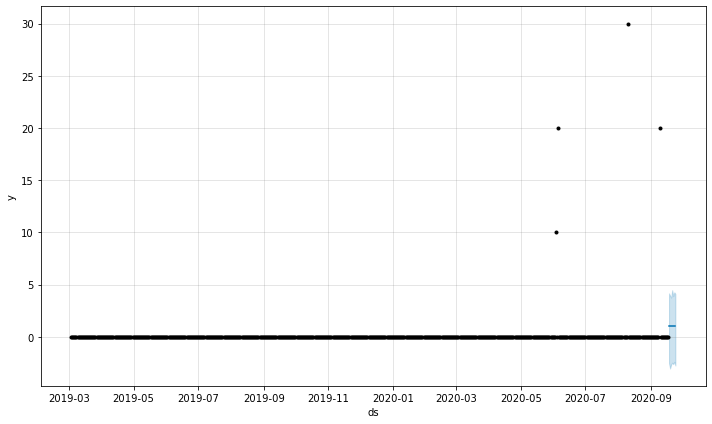

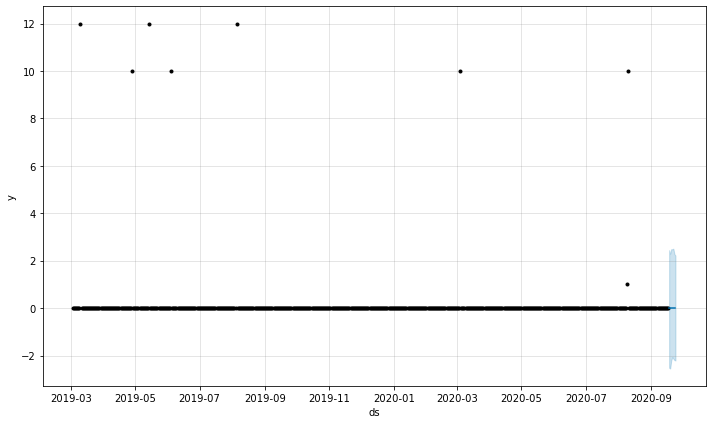

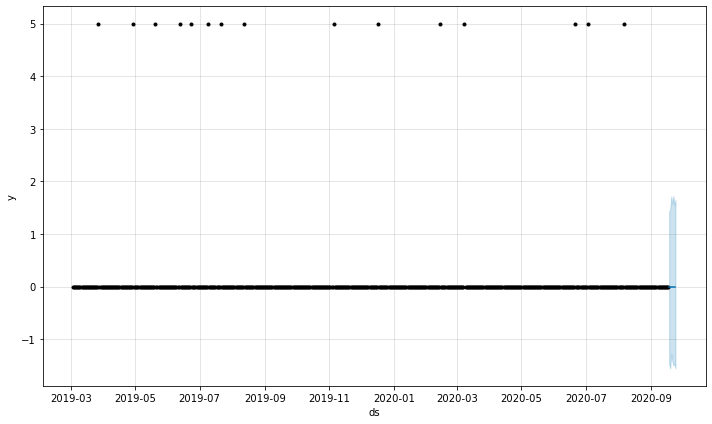

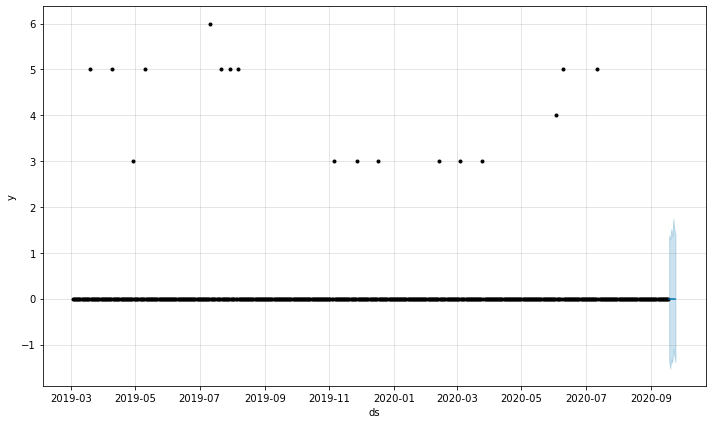

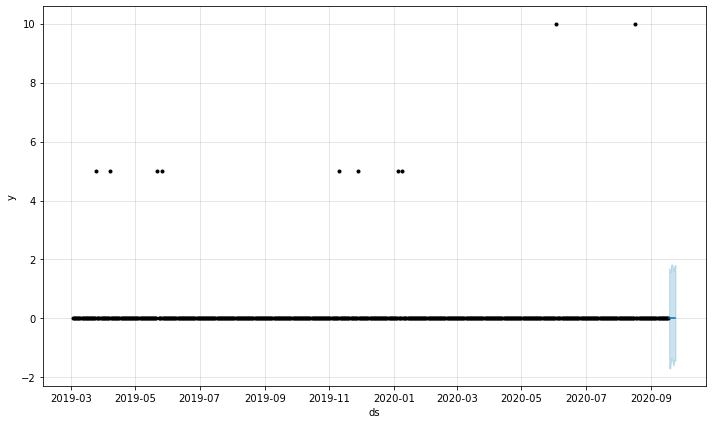

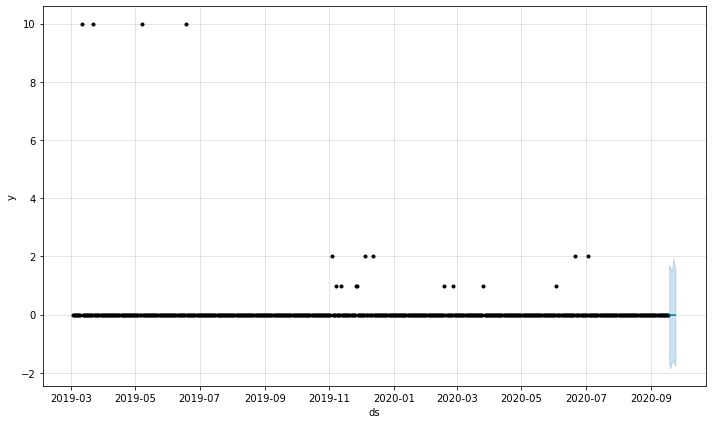

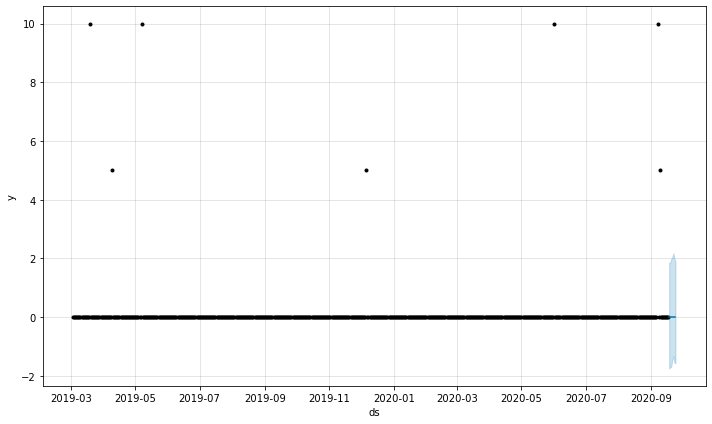

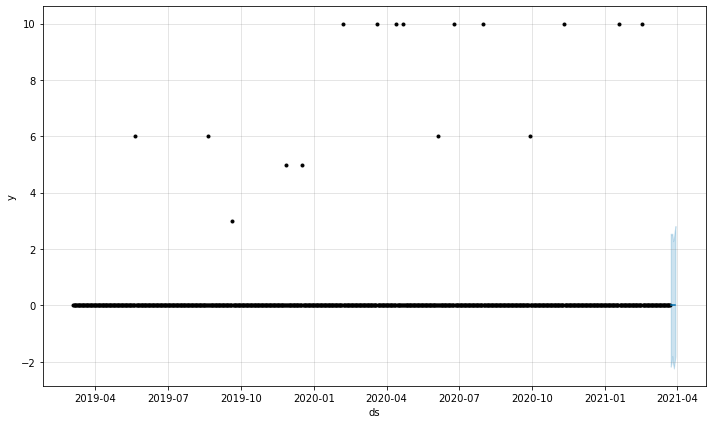

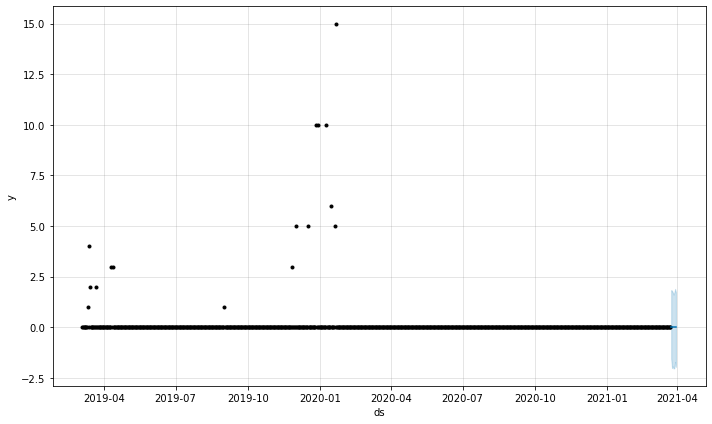

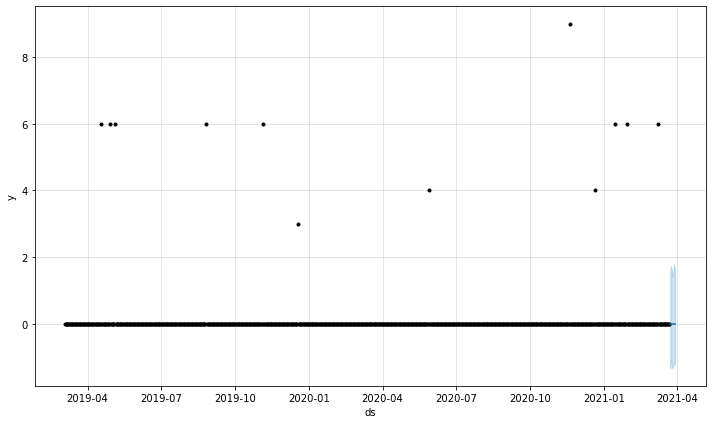

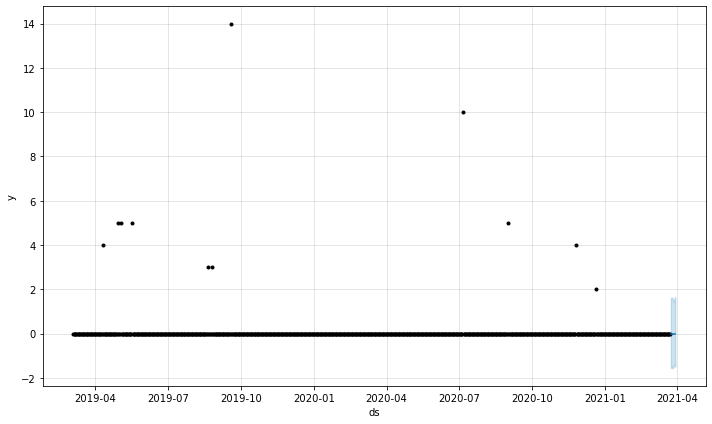

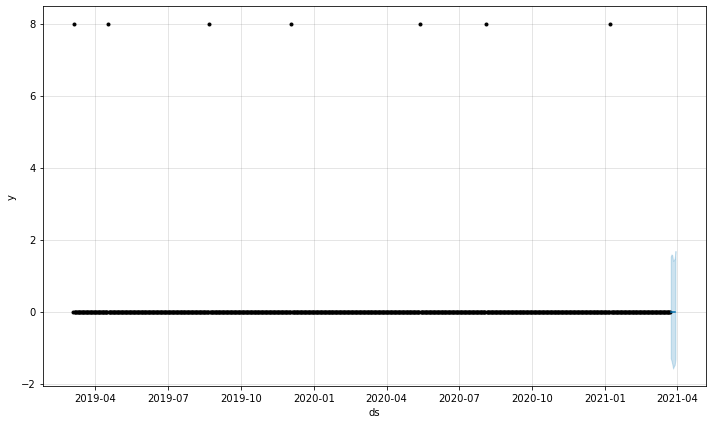

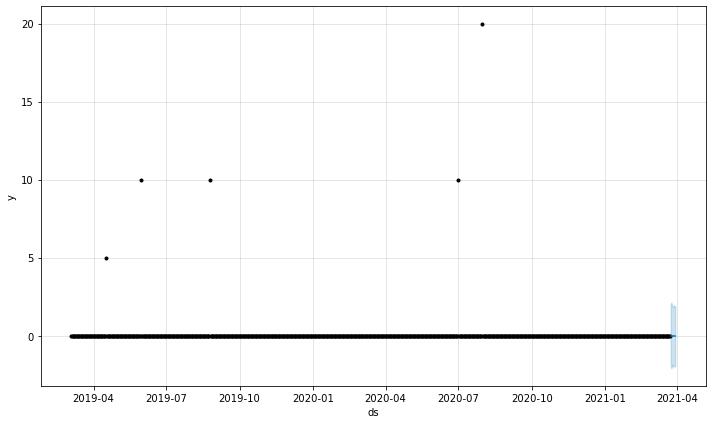

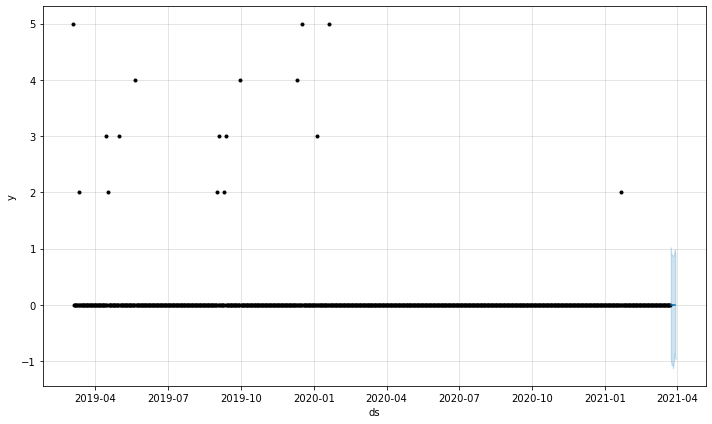

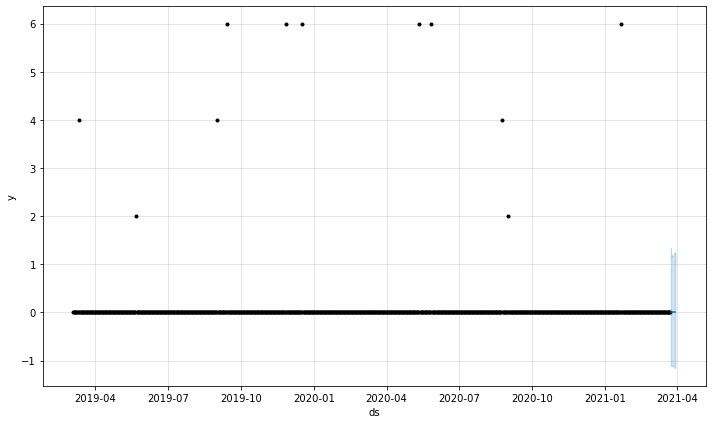

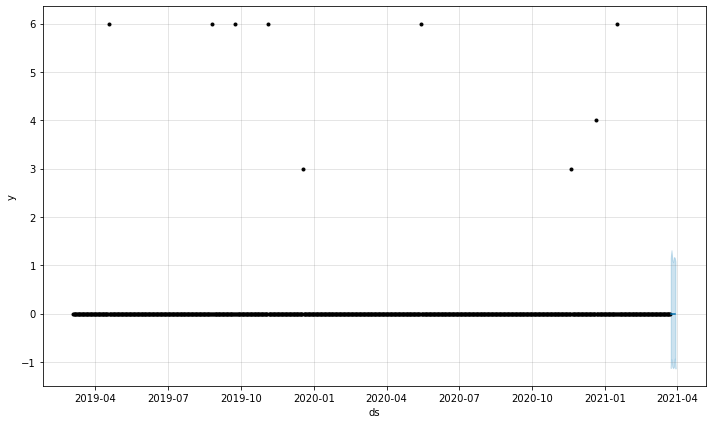

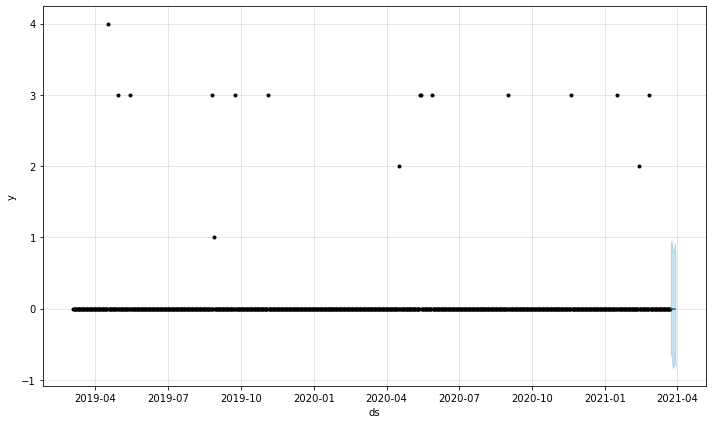

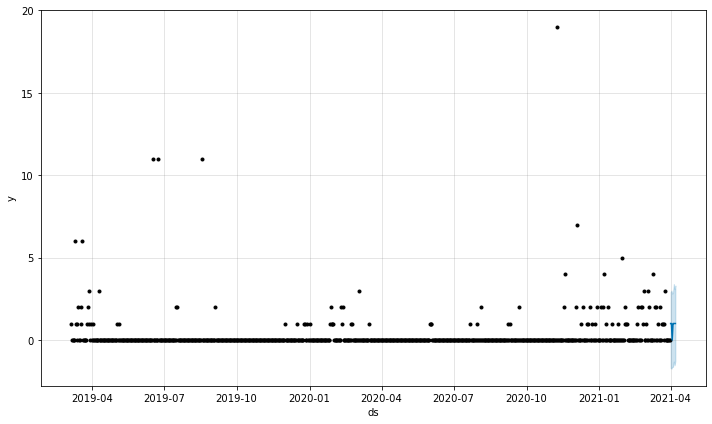

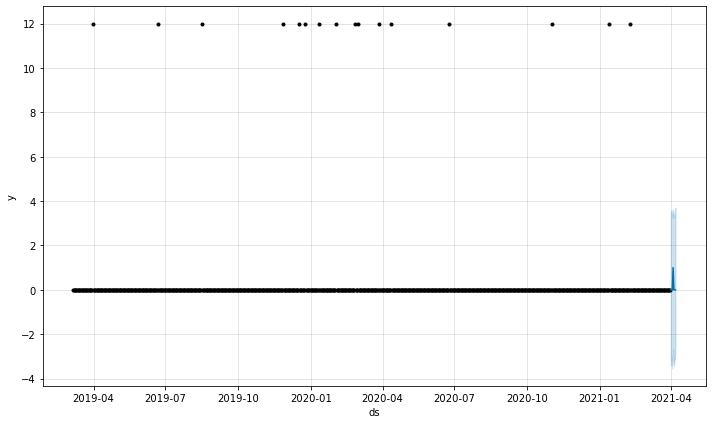

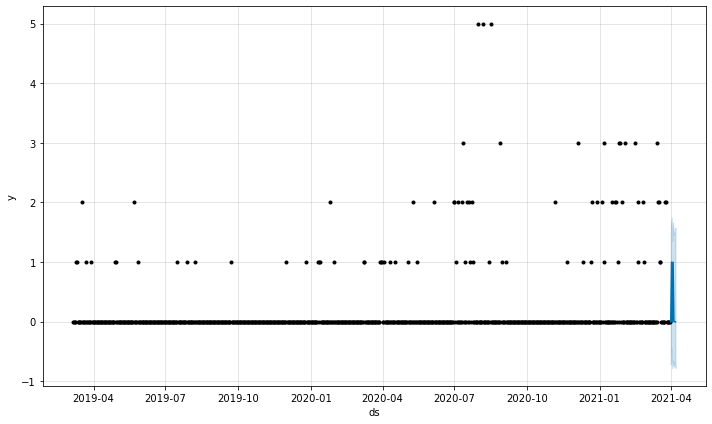

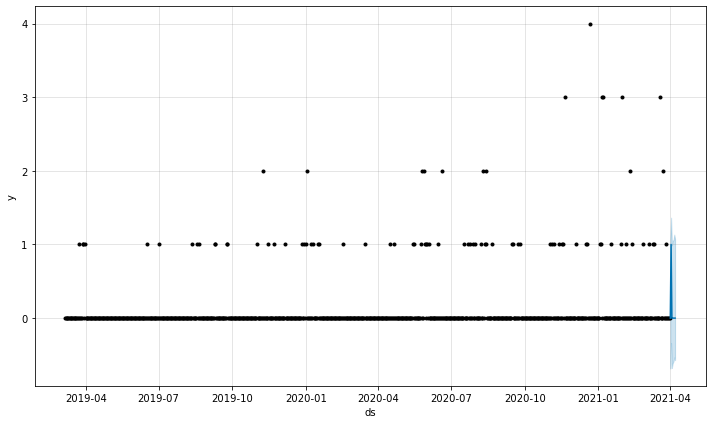

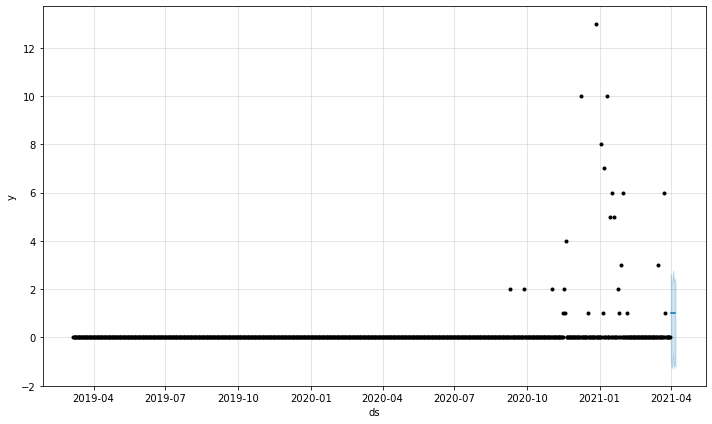

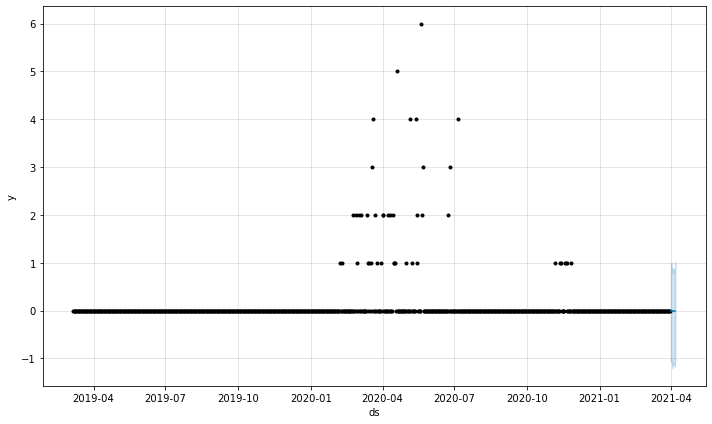

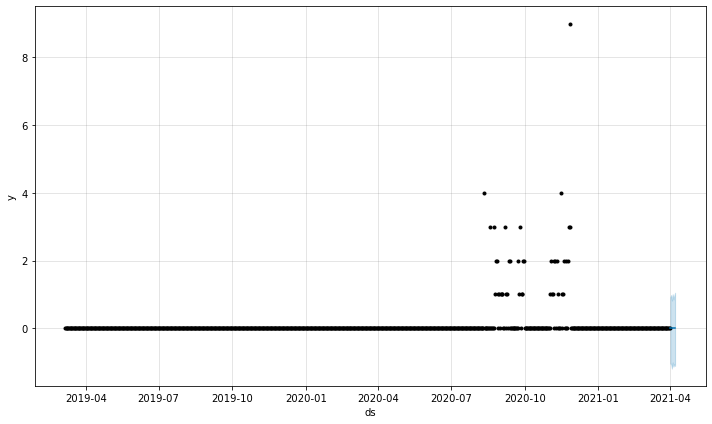

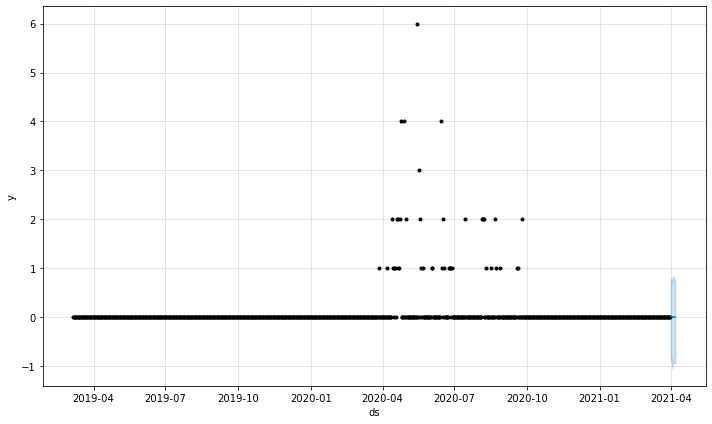

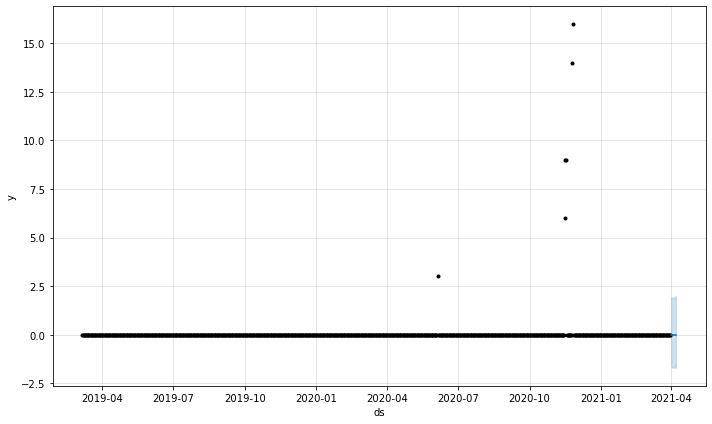

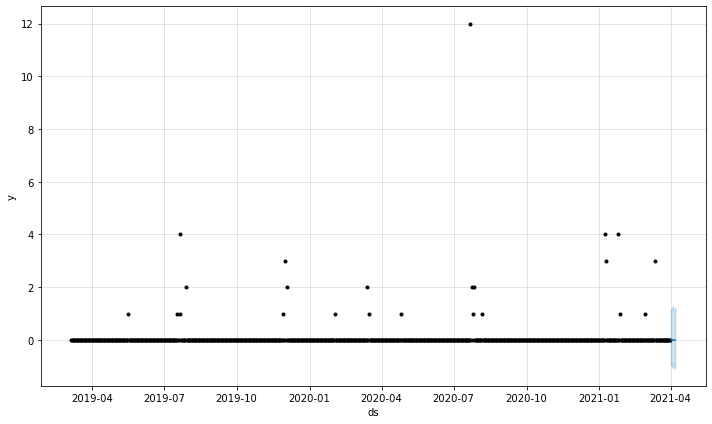

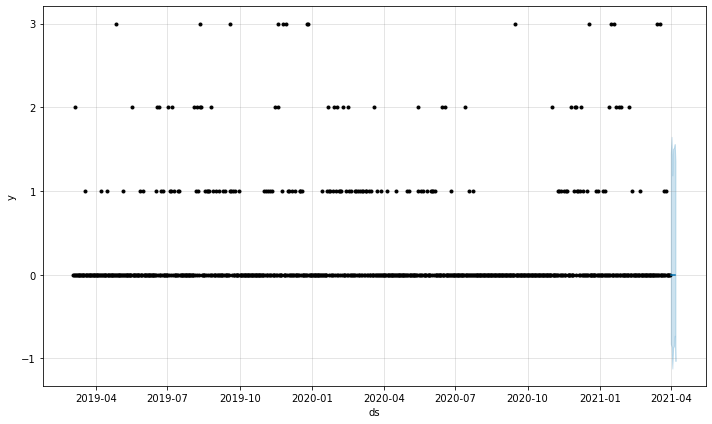

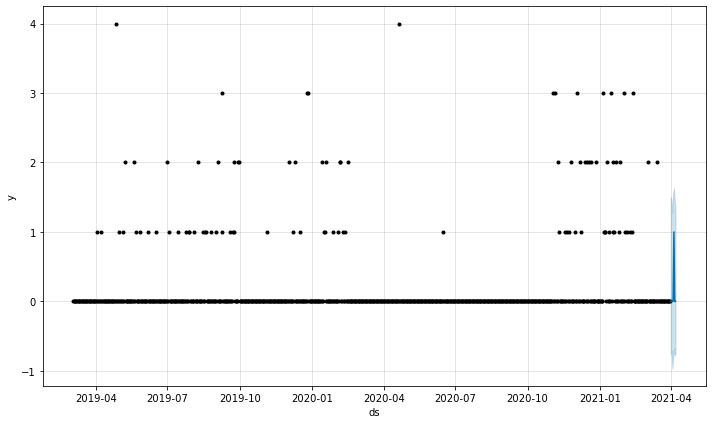

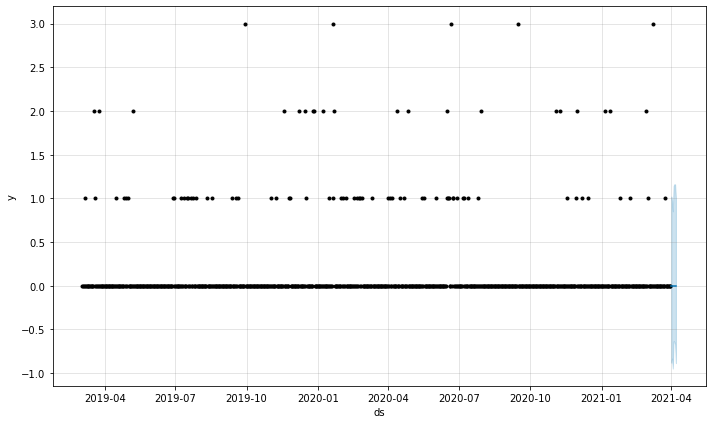

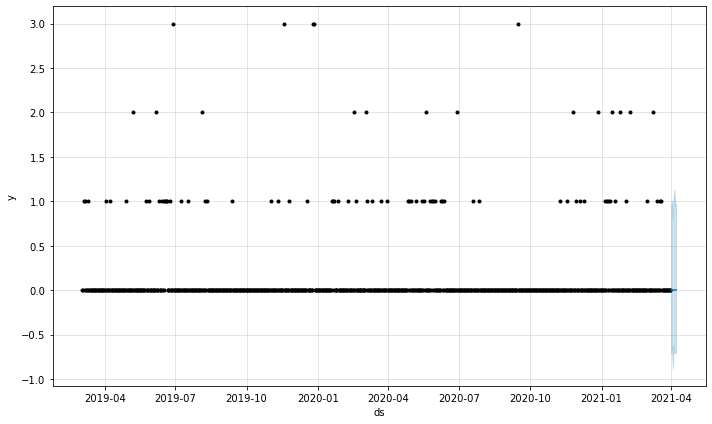

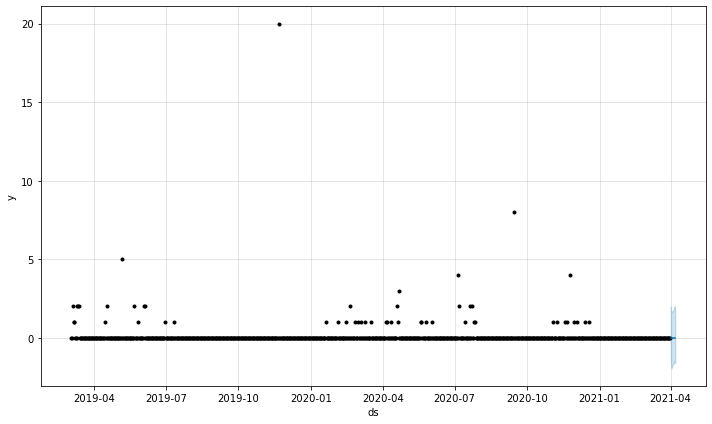

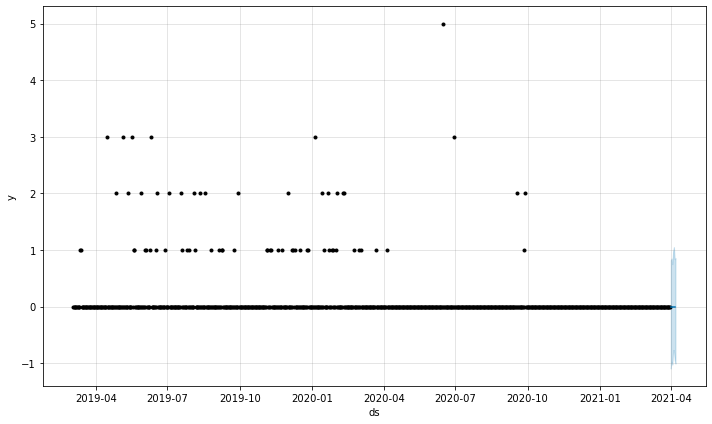

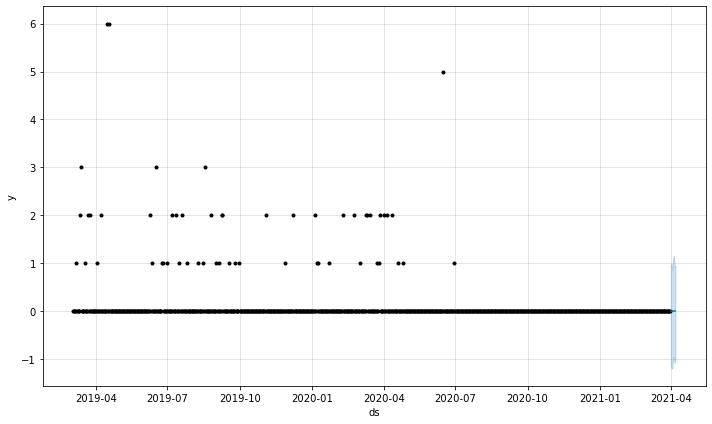

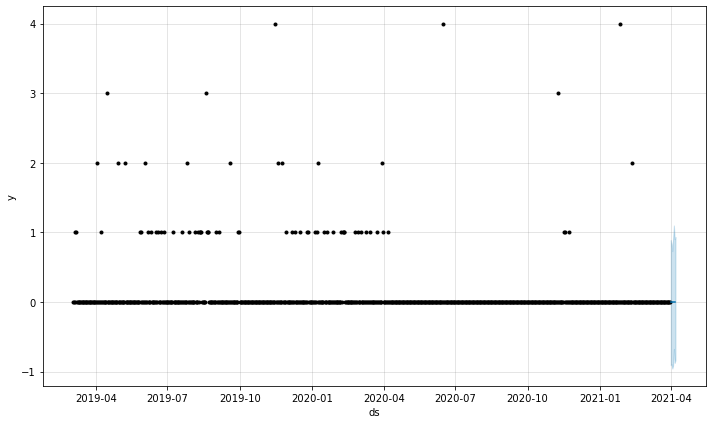

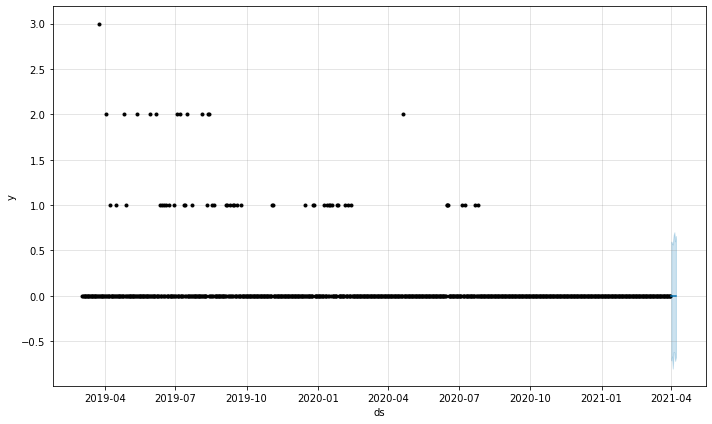

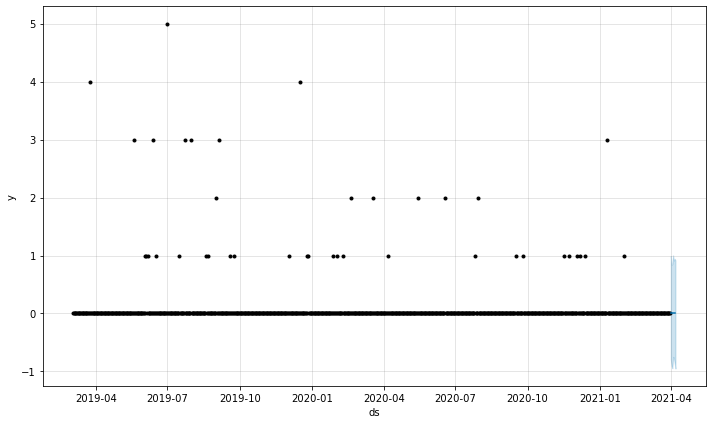

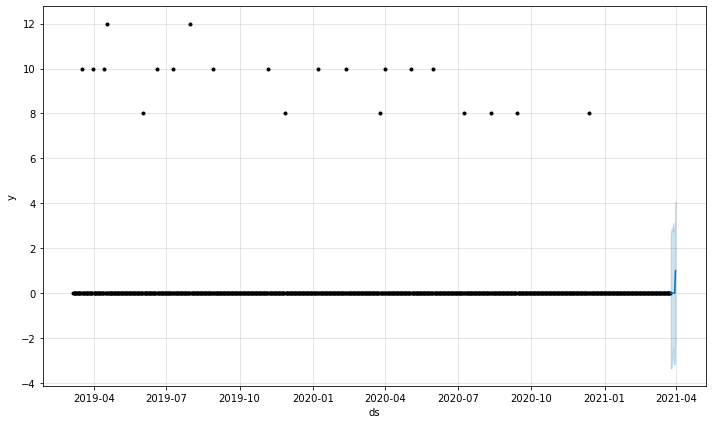

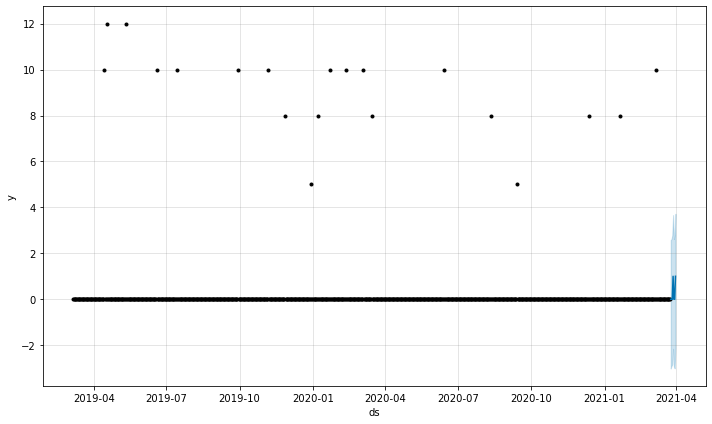

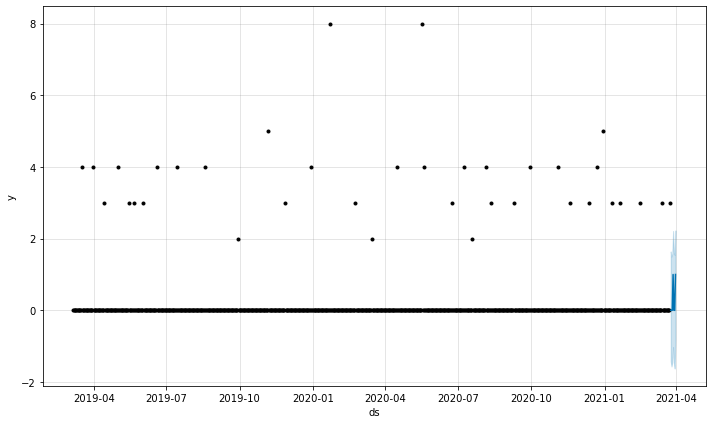

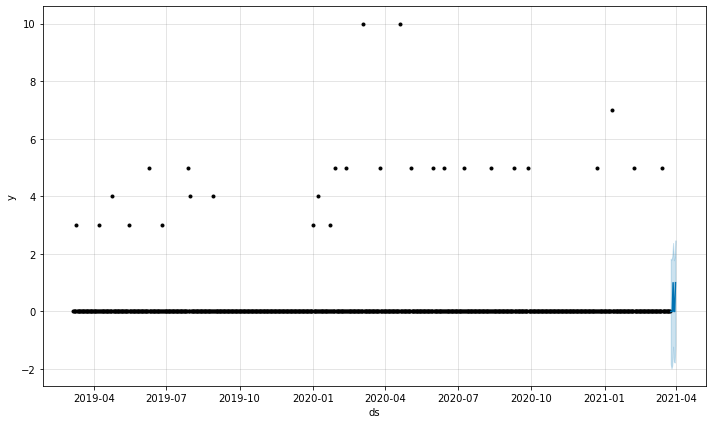

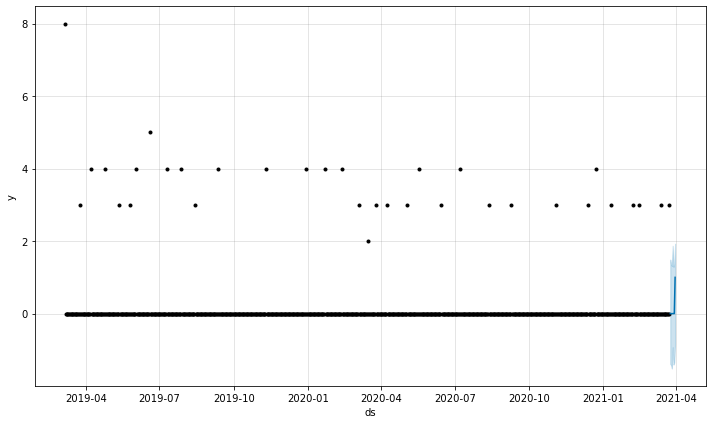

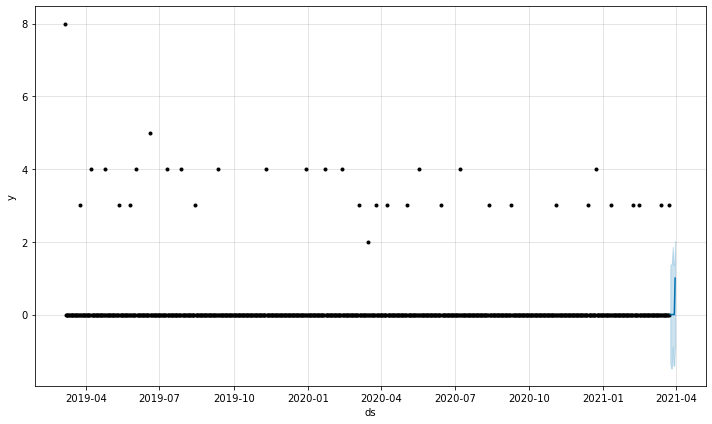

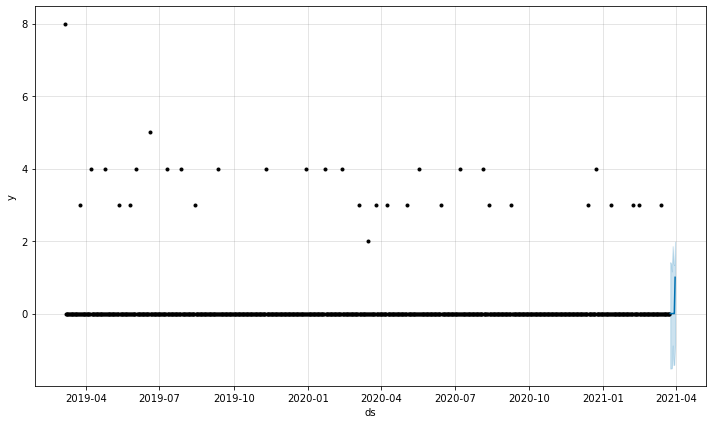

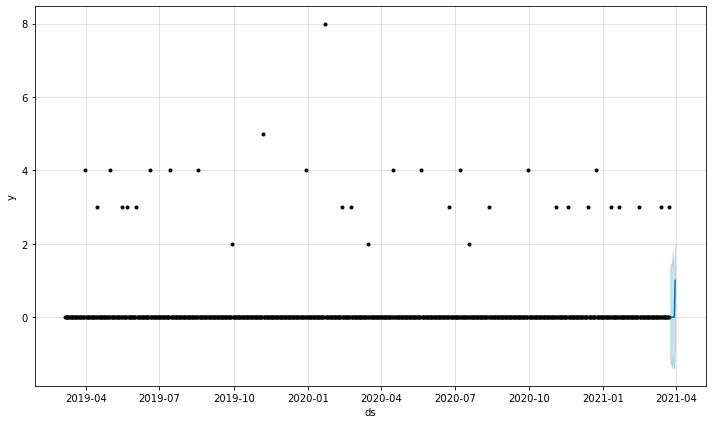

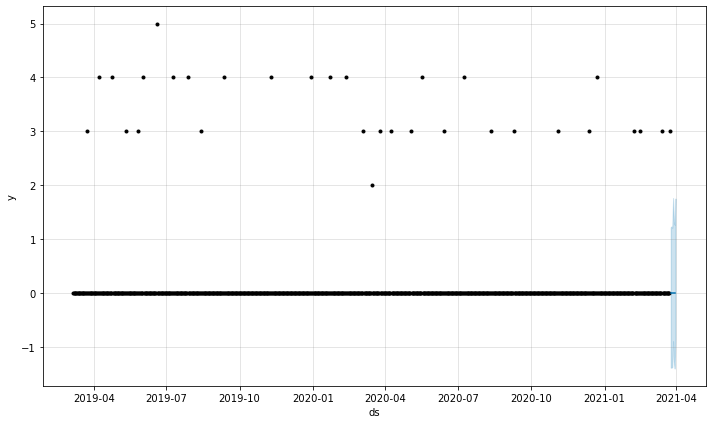

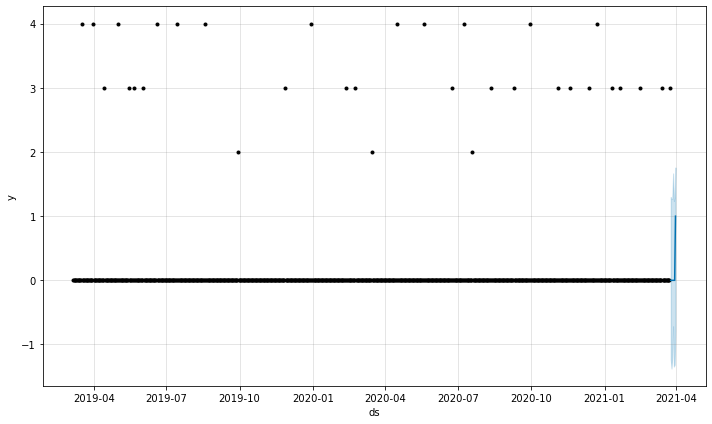

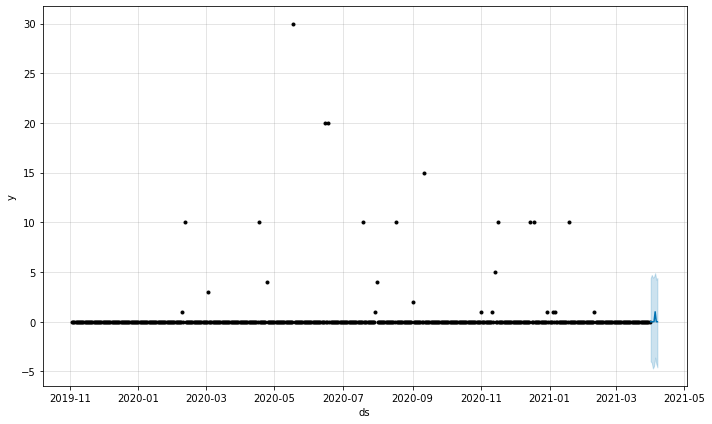

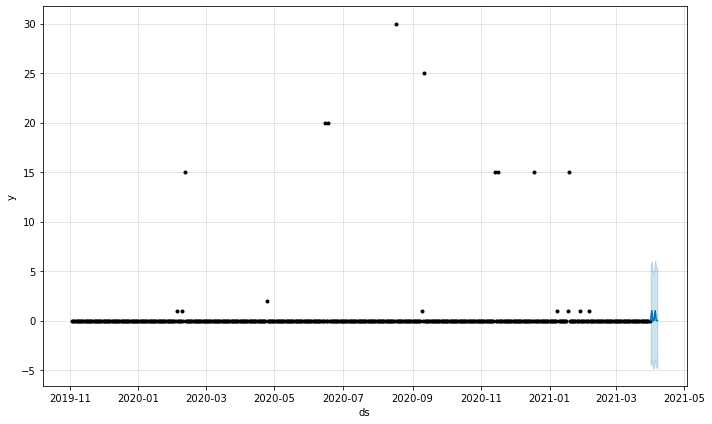

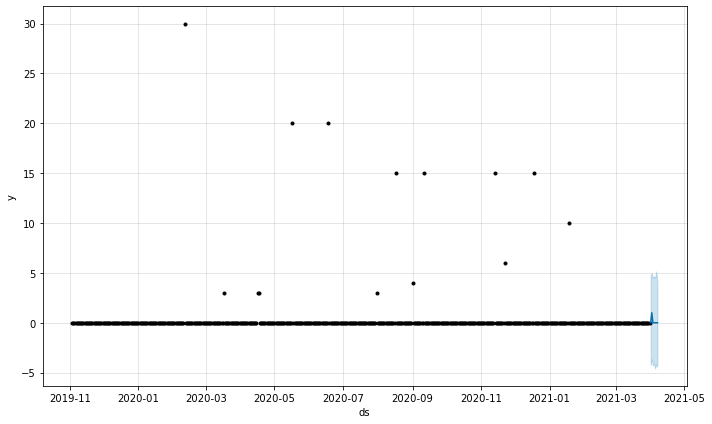

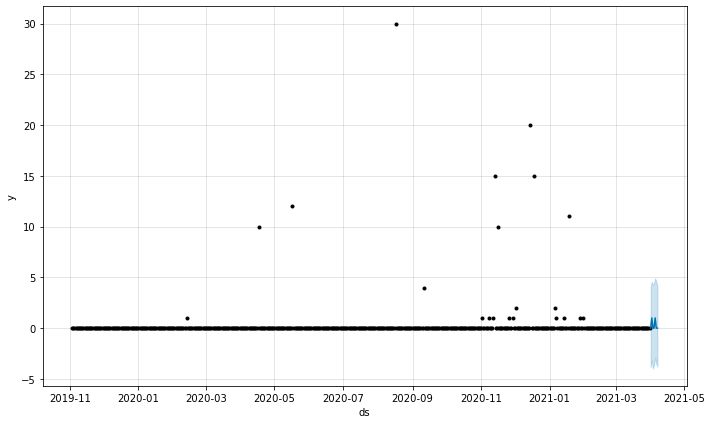

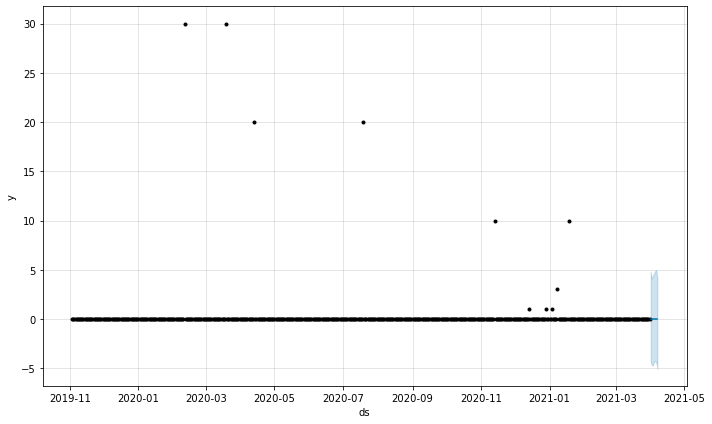

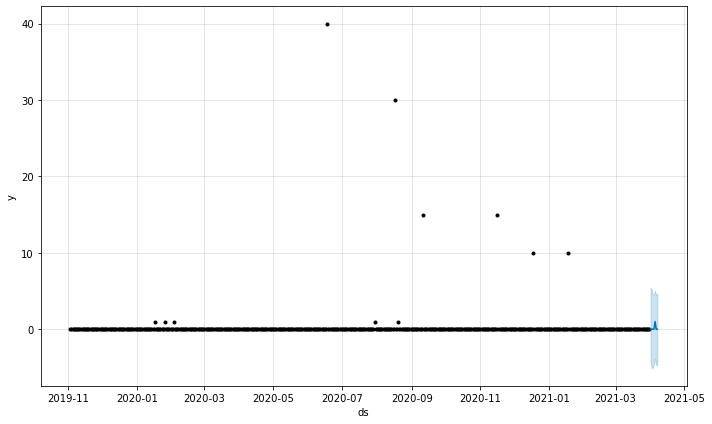

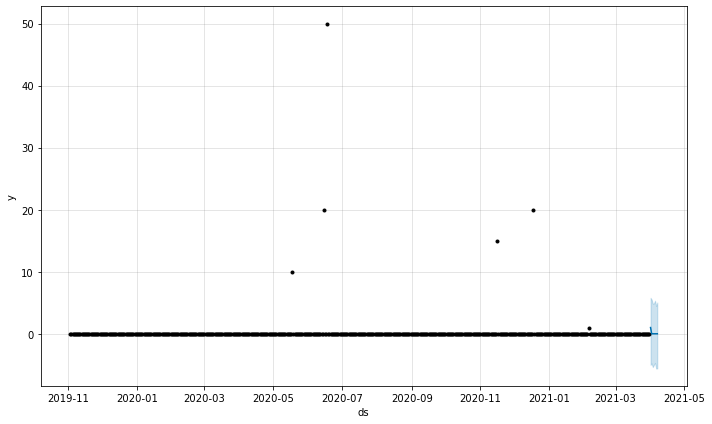

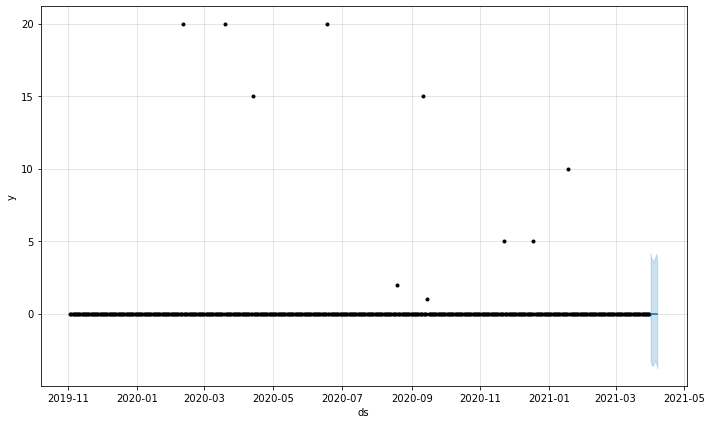

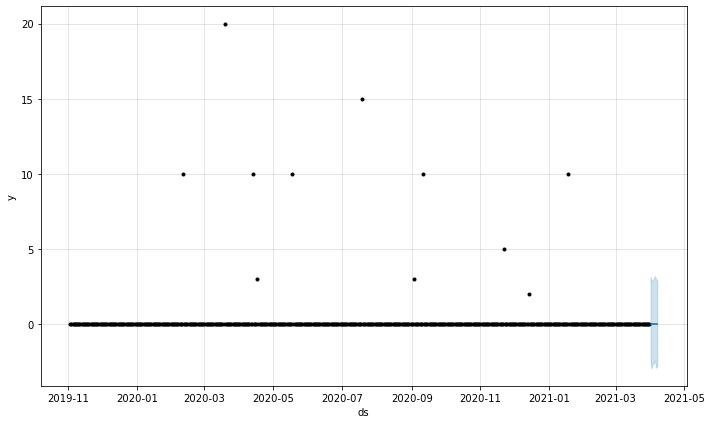

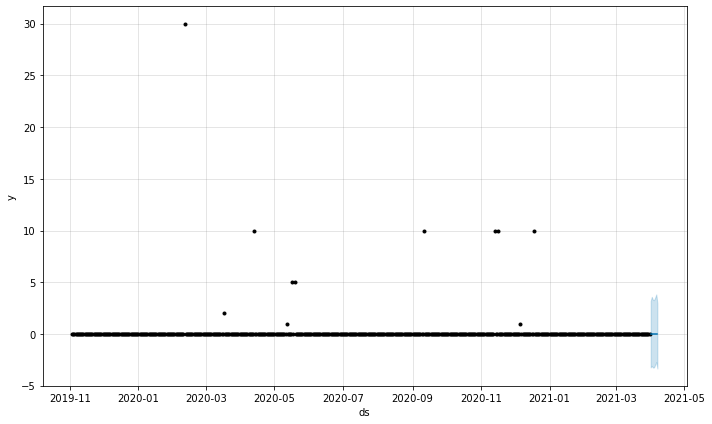

In [56]:
for store in stores_data:
    print(f'Store: {store}')
    for product in stores_data[store]['top_products_sales']:
        print(f'Product: {product}')
        stores_data[store]['fbp_objects'][product].plot(stores_data[store]['predictions'][product])


## Cross validation

In [ ]:
for store in stores_data:
    print(f'Store: {store}')
    number_days_training = math.floor(stores_data[store]['number_of_days']*0.9)
    number_days_verification = stores_data[store]['number_of_days'] - number_days_training - 1
    stores_data[store]['cv'] = {}
    stores_data[store]['cv_p'] = {}
    for product in stores_data[store]['top_products_sales']:
        df_cv = cross_validation(stores_data[store]['fbp_objects'][product], initial=f"{number_days_training} days", horizon=f"{number_days_verification} days")
        df_p = performance_metrics(df_cv)
        stores_data[store]['cv'][product] = df_cv
        stores_data[store]['cv_p'][product] = df_p
        print(df_cv.head())
        print(df_p.head())

INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


Store: data/sales-7017139


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.645
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69        1802.3    7.0407e-08       71.2189      0.2693           1       85   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14  0.327394   -8.089375    7.922681  0 2021-01-13
1 2021-01-15  0.843054   -6.957778    9.502151  0 2021-01-13
2 2021-01-16  0.328069   -8.042852    8.666847  0 2021-01-13
3 2021-01-17  0.328405   -8.510450    8.910707  0 2021-01-13
4 2021-01-18  1.555811   -6.096202   10.370373  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.524944  0.724530  0.578149    inf    2.0       1.0
1  8 days  0.525758  0.725092  0.579377    inf    2.0       1.0
2  9 days  0.527839  0.726525  0.580604    inf    2.0       1.0
3 10 days  0.528655  0.727086  0.581832    inf    2.0       1.0
4 11 days  0.529471  0.727648  0.583059    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.78656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1735.91    0.00019606       77.8338           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       1735.92   3.37142e-05       83.7526   3.614e-07       0.001      181  LS failed, Hessian reset 
     176       1735.93   5.32533e-08       71.3508      0.1813           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Skipping MAPE because y close to 0
INFO:prophet:Making 1 forecasts with cutoffs between 2021-01-13 00:00:00 and 2021-01-13 00:00:00


          ds      yhat  yhat_lower  yhat_upper  y     cutoff
0 2021-01-14 -0.206300   -3.896355    3.401268  0 2021-01-13
1 2021-01-15  0.305995   -3.498820    4.128705  0 2021-01-13
2 2021-01-16 -0.207772   -4.087061    3.456355  0 2021-01-13
3 2021-01-17  0.099313   -3.406846    3.989492  0 2021-01-13
4 2021-01-18 -0.209068   -4.016356    3.661466  0 2021-01-13
  horizon       mse      rmse       mae  mdape  smape  coverage
0  7 days  0.035251  0.187751  0.168788    inf    2.0       1.0
1  8 days  0.035670  0.188865  0.169788    inf    2.0       1.0
2  9 days  0.035065  0.187257  0.168788    inf    2.0       1.0
3 10 days  0.035488  0.188382  0.169788    inf    2.0       1.0
4 11 days  0.035296  0.187872  0.168788    inf    2.0       1.0


  0%|          | 0/1 [00:00<?, ?it/s]

Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1888.17    2.7256e-06       60.9358      0.3541           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       1888.19   0.000121593       92.1099   1.483e-06       0.001      213  LS failed, Hessian reset 
     175        1888.2   1.28597e-07       64.6762      0.6437      0.9496      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
